
# Flight Delay Prediction Project


## Part 1 : Preparing the Data for Analysis

In this part, we will import all the files, load entire dataset and clean the data and create data visualizations.

In this project, I have used last 4 months of data from the [Bureau of Transportation Statistics](https://www.bts.gov/) to find out which airlines cause delays on given a particular route, at a particular time.
The weather data used in later parts of this project is obtained from [National Centers for Environmental Information](https://www.ncdc.noaa.gov) for the same time frame for top 50 Airports.

Last 4 months: 2020: Nov - Dec & 2021: Jan-Feb



In [ ]:
# Libraries and Packages
import os
import pandas as pd
import numpy as np
from os import walk
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [ ]:
# Keeping a tab on time required for accessing the data.
tic = time.time()

os.chdir("/content/drive/MyDrive/Projects/Flight_Delay_Predict_Project") #Default Project directory

#Read all the airline data files present in the folder 'data'
df = pd.DataFrame()

f = []
for (dirpath,dirnames,filenames) in walk('data/flight/'):
    f.extend(filenames)
    break
    
for file in f[1:]:
    df = df.append(pd.read_csv('data/flight/'+file))
    
toc = time.time()
print(toc-tic)

6.891077995300293


##Cleaning up the Data


*   Remove the columns which are not relevant in predicting the delays.
*   Drop rows that have no values or NaNs in the 'OP_CARRIER','ORIGIN','DEST','CRS_DEP_TIME','CRS_ARR_TIME','ARR_DELAY','CRS_ELAPSED_TIME','DISTANCE' fields. 



In [ ]:
#Remove columns which are not used in analysis
df.drop(['ORIGIN_STATE_ABR','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','DEST_STATE_ABR'],axis=1,inplace=True)

#Delete the categorized delay variables because less than 10% records have these data. Rest are NaNs
df.drop(['Unnamed: 27','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY'],axis=1,inplace=True)

In [ ]:
#Drop rows with missing data in the important columns, i.e. the predictors for flight delay
total_data_rows = len(df.index)
#Drop NaNs
df.dropna(subset = ['OP_CARRIER','ORIGIN','DEST','CRS_DEP_TIME','CRS_ARR_TIME','ARR_DELAY','CRS_ELAPSED_TIME','DISTANCE'],inplace=True)
data_retained = len(df.index)/total_data_rows
print('Data Retained: '+str(round(data_retained*100,2))+' %')

Data Retained: 97.56 %


## Prepare the data


*   Change the Arrival and Departure timestamps to nearest rounded hour and not the actual time in minutes.



In [ ]:
#Get the Departure and Arrival Hours
#For DEP_HOUR, take the CRS_DEP_TIME
df['DEP_HOUR'] = df['CRS_DEP_TIME'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
#For ARR_HOUR, take the actual arrival time
df['ARR_HOUR'] = df['ARR_TIME'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
df['ARR_HOUR'] = df['ARR_HOUR'].apply(lambda x:0 if x==24 else x)

In [ ]:
#Save the Dataframe as .csv file
tic = time.time()
df.to_csv('CodeFiles/Full_airline_data.csv',index=False)
toc = time.time()
print(toc-tic)

11.031009435653687


## Initial Data Exploration

In [ ]:
#Total number of flights in our dataset:
len(df.index)

1042127

In [ ]:
#Average number of flights per day from 2020 November to 2021 February:
len((df[df['YEAR']==2020].index)+(df[df['YEAR']==2020].index))/120

6072.825

In [ ]:
#Percent of flights with delays greater than 15 minutes:
len(df[df['ARR_DELAY']>15].index)/len(df.index)

0.10653883835655348

In [ ]:
#Head of the data:
df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DEP_HOUR,ARR_HOUR
0,2021,2,19,5,OH,5581,CLT,OKC,1310,1306.0,-4.0,1510,1459.0,-11.0,180.0,173.0,145.0,940.0,13,14
1,2021,2,21,7,OH,5581,CLT,OKC,1310,1304.0,-6.0,1510,1513.0,3.0,180.0,189.0,162.0,940.0,13,15
2,2021,2,22,1,OH,5581,CLT,OKC,1310,1306.0,-4.0,1510,1454.0,-16.0,180.0,168.0,144.0,940.0,13,14
3,2021,2,25,4,OH,5581,CLT,OKC,1310,1306.0,-4.0,1510,1516.0,6.0,180.0,190.0,153.0,940.0,13,15
4,2021,2,26,5,OH,5581,CLT,OKC,1310,1303.0,-7.0,1510,1456.0,-14.0,180.0,173.0,145.0,940.0,13,14


## Arrival Delay Visualizations

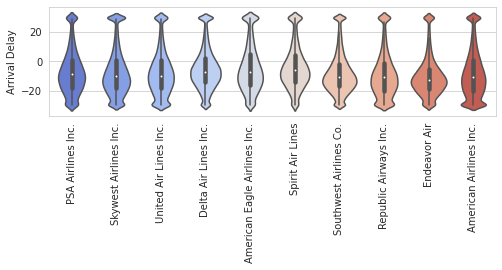

In [ ]:
#Visualize the ARR_DELAYS for top 10 airlines

#Get the list of the 10 biggest Airline Carriers
top10_carrier = list(df['OP_CARRIER'].value_counts().head(10).index)
df_sub = df[df['OP_CARRIER'].isin(top10_carrier)][['OP_CARRIER','ORIGIN','DEST','ARR_DELAY']]

#Read the Carrier Key CSV file for full names of the Airlines
carrier_key = pd.read_csv('data/airline/airlines.csv')

#Merge with the dataframe containing the 10 biggest Airline Carriers
df_sub = pd.merge(df_sub,carrier_key,how='left',left_on='OP_CARRIER', right_on='IATA_CODE')

#Create a copy of the dataframe for Violin plot. Delays greater than 30 minutes are clubbed to show the data at the same scale
df_temp = df_sub.copy()
#All delays greater than 30 minutes are clubbed at 30
df_temp['ARR_DELAY'] = df_temp['ARR_DELAY'].apply(lambda x:30 if x>=30 else x)
df_temp['ARR_DELAY'] = df_temp['ARR_DELAY'].apply(lambda x:-30 if x<=-30 else x)


#Create the plot in seaborn
plt.figure(figsize=(8, 2))
g = sns.violinplot(x="AIRLINE", y="ARR_DELAY", data=df_temp,palette="coolwarm")
g.set_ylabel('Arrival Delay')
g.set_xlabel('')
label = g.set_xticklabels(g.get_xticklabels(), rotation=90)
fig = g.get_figure()
fig.savefig("CodeFiles/delay_violin_plot.png", bbox_inches='tight')

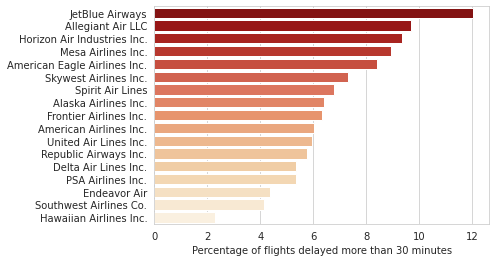

In [ ]:
#Plot percentage of flights delayed more than 30 minutes

carrier_delay = pd.DataFrame()

for UC in list(df['OP_CARRIER'].unique()):
    perc_delayed = len(df[(df['OP_CARRIER']==UC) & (df['ARR_DELAY']>=30)].index)/len(df[df['OP_CARRIER']==UC].index)*100
    carrier_delay = carrier_delay.append({'OP_CARRIER':UC,'percent_delayed' : perc_delayed},ignore_index=True)

carrier_delay = pd.merge(carrier_delay,carrier_key,how='left',left_on='OP_CARRIER', right_on='IATA_CODE')
carrier_delay.drop(['OP_CARRIER','IATA_CODE'],axis=1,inplace=True)
carrier_delay.rename(index=str,columns={'AIRLINE':'Airline'},inplace=True)
#Sort by percentage delayed
carrier_delay.sort_values(by = ['percent_delayed'],ascending=False,inplace=True)


color_pal = sns.color_palette("OrRd", len(carrier_delay.index))
color_pal = color_pal[::-1]

plt.figure(figsize=(6, 4))
g = sns.barplot(x="percent_delayed", y="Airline", data=carrier_delay,palette=color_pal)
g.set_ylabel('')
g.set_xlabel('Percentage of flights delayed more than 30 minutes')
fig = g.get_figure()
fig.savefig("CodeFiles/carrier_delay.png", bbox_inches='tight')

In [ ]:
carrier_delay

,percent_delayed,Airline
16,12.042054,JetBlue Airways
6,9.700593,Allegiant Air LLC
2,9.370921,Horizon Air Industries Inc.
11,8.948524,Mesa Airlines Inc.
8,8.409215,American Eagle Airlines Inc.
1,7.313184,Skywest Airlines Inc.
9,6.787356,Spirit Air Lines
15,6.408058,Alaska Airlines Inc.
5,6.333837,Frontier Airlines Inc.
14,6.024606,American Airlines Inc.


In [ ]:
del df_temp
del carrier_delay
del df_sub

## Top 50 Airports (by Traffic - number of Departures and Arrivals)

We again take the entire dataset and get the list of top 50 airports by traffic, calculated on the number of arrivals and departures. Then we plot these 50 airports on the map os USA using plotly and cfflinks

In [ ]:
#Create a new dataframe combining the Arrival and Destination Airports in one column
df_airport = pd.DataFrame(pd.concat([df['ORIGIN'],df['DEST']]),columns={'IATA'})

#Select the Top 50 Airports 
df_top50 = pd.DataFrame(df_airport['IATA'].value_counts().head(50)).reset_index()
df_top50.rename(index=str, columns={"index":"IATA","IATA":"Count"},inplace=True)
del df_airport

For plotting this data we import the airport Latitude and Longitude obtained from [OpenFlights.org](https://openflights.org/data.html)

In [ ]:
#Read Airport data
df_airports = pd.read_csv('data/airport/airports.dat')
df_airports = df_airports[df_airports['Country']=='United States'][['IATA','Latitude','Longitude']].copy()

In [ ]:
#Merge with the DataFrame containing the list of Top 50 Airports
df_top50 = pd.merge(df_top50,df_airports,how='left',on="IATA")

In [ ]:
#Save the top 50 airports in a CSV file
df_top50.to_csv('CodeFiles/top50airports.csv',index=False)

In [ ]:
#Map the Airports as a Bubble map, with size corresponding to Traffic

import plotly.offline as py

#First create a new columns with Textual information
df_top50['text'] = df_top50['IATA'] + '<br>Total Flights: ' + (df_top50['Count']/1e3).astype(str)+' (Thousands)'

#Create plot using Plotly
limits = [(0,10),(11,30),(31,50)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)"]
names = ["Top 10 Busiest","11-30","31-50"]
cities = []
scale = 2500

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_top50[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['Longitude'],
        lat = df_sub['Latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Count']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = names[i] )
    cities.append(city)
    
layout = dict(
        title = 'Top 50 Busiest Airports by Traffic',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=cities, layout=layout )
py.iplot(fig, validate=False)
py.plot(fig, validate=False, filename='CodeFiles/d3-map-airports.html')

'CodeFiles/d3-map-airports.html'

## Plotting flight paths with average delay of more than 10 minutes

In [ ]:
#Make subset of data containing only flights from top 50 airports
top50_airport = df_top50['IATA'].tolist()
df_sub = df[df['ORIGIN'].isin(top50_airport)]
df_sub = df_sub[df_sub['DEST'].isin(top50_airport)]

#Check the % of data retained:
data_retained = len(df_sub.index)/len(df.index)
print('Data Retained: '+str(round(data_retained*100,2))+' %')

Data Retained: 56.39 %


In [ ]:
#Create a dataframe of airports for plotting (top50)
df_airports = pd.DataFrame(df_sub['ORIGIN'].unique())
df_airports.rename(index=str,columns={0:'IATA'},inplace=True)

#Read Airport coordinates
df_airport_coord = pd.read_csv('data/airport/airports.dat')
df_airport_coord = df_airport_coord[df_airport_coord['Country']=='United States'][['IATA','Latitude','Longitude']].copy()
df_airports = pd.merge(df_airports,df_airport_coord,how='left',on="IATA")


#Read Airport Full Names
airport_key = pd.read_csv('data/airport/airports.csv')
airport_key.rename(index=str, columns={"IATA_CODE": "IATA"},inplace=True)
df_airports = pd.merge(df_airports,airport_key,how='left',on='IATA')

In [ ]:
#Create a flights dataframe for plotting flight paths
df_flights = df_sub[['ORIGIN','DEST','ARR_DELAY']].groupby(by=['ORIGIN','DEST']).mean()
df_flights.reset_index(inplace=True)
df_flights['ARR_DELAY'] = df_flights['ARR_DELAY'].apply(lambda x:0 if x<0 else round(x))
df_flights.dropna(inplace=True)
#Select only flight paths with average delay of more than 10 minutes
df_flights = df_flights[df_flights['ARR_DELAY']>=10]

In [ ]:
#Add start and end latitude and longitude for each flight
df_flights = pd.merge(df_flights,df_airports[['IATA','Latitude','Longitude']],how='left',left_on = 'ORIGIN', right_on = 'IATA')
df_flights.rename(index=str, columns={"Latitude": "start_lat"},inplace=True)
df_flights.rename(index=str, columns={"Longitude": "start_lon"},inplace=True)

df_flights = pd.merge(df_flights,df_airports[['IATA','Latitude','Longitude']],how='left',left_on = 'DEST', right_on = 'IATA')
df_flights.rename(index=str, columns={"Latitude": "end_lat"},inplace=True)
df_flights.rename(index=str, columns={"Longitude": "end_lon"},inplace=True)

df_flights.drop(['IATA_x','IATA_y'],axis=1,inplace=True)

In [ ]:
#Remove Honolulu
df_flights = df_flights[df_flights['ORIGIN']!='HNL'].copy()
df_flights = df_flights[df_flights['DEST']!='HNL'].copy()
df_airports = df_airports[df_airports['IATA']!='HNL'].copy()

In [ ]:
import plotly.offline as py

airports = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_airports['Longitude'],
        lat = df_airports['Latitude'],
        hoverinfo = 'text',
        text = df_airports['AIRPORT'],
        mode = 'markers',
        marker = dict( 
            size=2, 
            color='rgb(0, 0, 0)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ))]
        
flight_paths = []
for i in range( len( df_flights ) ):
    flight_paths.append(
        dict(
            type = 'scattergeo',
            locationmode = 'USA-states',
            lon = [ df_flights['start_lon'][i], df_flights['end_lon'][i] ],
            lat = [ df_flights['start_lat'][i], df_flights['end_lat'][i] ],
            mode = 'lines',
            line = dict(
                #width = 5,
                width = (float((df_flights['ARR_DELAY'][i]-1)-df_flights['ARR_DELAY'].min())/(float(df_flights['ARR_DELAY'].max()-df_flights['ARR_DELAY'].min())/2.0))+2,
                color = 'red'
            ),
            #opacity = 1
            opacity = float(df_flights['ARR_DELAY'][i])/float(df_flights['ARR_DELAY'].max()),
        )
    )
    
layout = dict(
        title = 'Routes with an average delay of more than 10 minutes (2020-11 to 2021-02)',
        showlegend = False, 
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            #scope='north america',
            #projection=dict( type='azimuthal equal area' ),
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict( data=flight_paths + airports, layout=layout )
py.iplot( fig, filename='d3-flight-paths' )
py.plot( fig, filename='CodeFiles/d3-flight-paths.html' )

'CodeFiles/d3-flight-paths.html'